In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 65.7 MB/s eta 0:00:00


In [ ]:
import requests as rq
import pandas as pd

shootings_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=73c7e069-701f-4910-986d-b950f46c91a1&limit=10000"
shootings = pd.DataFrame((rq.get(url = shootings_URL)).json().get('result').get('records'))

In [ ]:
crime_incidents_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=b973d8cb-eeb2-4e7e-99da-c92938efc9c0&limit=5000000000"
crime_incidents = pd.DataFrame((rq.get(url = crime_incidents_URL)).json().get('result').get('records'))

In [ ]:
city_council_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=7918a624-2c23-493a-8d13-1c8fbd085e2d&limit=5000000000"
city_councils = pd.DataFrame((rq.get(url = city_council_URL)).json().get('result').get('records'))

In [ ]:
common_ids = set(shootings['_id']).intersection(set(crime_incidents['_id']))

In [ ]:
shootings = pd.merge(shootings, crime_incidents[['Long', 'Lat', '_id']], on='_id', how='inner')

In [ ]:
shootings.head(5)

,shooting_type_v2,victim_ethnicity_NIBRS,district,incident_num,victim_race,multi_victim,victim_gender,_id,shooting_date,Long,Lat
0,Non-Fatal,Not Hispanic or Latinx,C11,I152000196-00,Black or African American,f,Male,1,2015-01-01 13:30:00+00,-71.05970910242573,42.29755532959655
1,Non-Fatal,Not Hispanic or Latinx,E18,I152000879-00,Black or African American,f,Male,2,2015-01-04 01:58:00+00,-71.1028481652423,42.32243204632895
2,Non-Fatal,Not Hispanic or Latinx,E5,I152001014-00,Black or African American,f,Male,3,2015-01-04 18:52:00+00,-71.06940876967543,42.33954198983014
3,Non-Fatal,Not Hispanic or Latinx,B2,I152002232-00,Black or African American,t,Male,4,2015-01-08 22:45:00+00,-71.10429431787648,42.30971856767274
4,Non-Fatal,Not Hispanic or Latinx,B2,I152002233-00,Black or African American,t,Female,5,2015-01-08 22:45:00+00,-71.15049849975023,42.34905600030506


## Community Center

# New Section

In [ ]:
import pandas as pd
# Sarahs one
community_centers = pd.read_csv('/content/drive/MyDrive/Team 3/Deliverables/Proposal Deliverables/data/community_centers/community_centers_city_council.csv')
# Work with Brians thing
# community_centers = pd.read_csv('/content/drive/Shareddrives/CS506/SP23 Gun Violence - Councilor Worrell /Team 3/Deliverables/Proposal Deliverables/data/community_centers/community_centers_city_council.csv')

In [ ]:
from pyproj import Transformer

def point_to_coords(point_str):
    point_str = point_str.replace('POINT (', '').replace(')', '')
    x, y = point_str.split()
    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    lon, lat = transformer.transform(x, y)
    return lon, lat

community_centers[['long', 'lat']] = community_centers['geometry'].apply(lambda x: pd.Series(point_to_coords(x)))

print(community_centers.keys())

Index(['FID', 'OBJECTID', 'SITE', 'PHONE', 'FAX', 'STREET', 'NEIGH', 'ZIP',
       'geometry', 'city_council_id', 'long', 'lat'],
      dtype='object')


In [ ]:
shootings.dropna(inplace=True)
community_centers.dropna(inplace=True)

shootings['Lat'] = shootings['Lat'].apply(float)
shootings['Long'] = shootings['Long'].apply(float)

In [ ]:
shootings.shape

(1646, 11)

In [ ]:
from geopy import distance

black = 'Black or African American'
white = 'White'
asian = 'Asian'
unknown = 'Unknown'
male = 'Male'
female = 'Female'
single = 'f'
multiple = 't'
fatal = 'Fatal'
non_fatal = 'Non-Fatal'
hispanic = 'Hispanic or Latinx'
non_hispanic = 'Not Hispanic or Latinx'

def count_shootings_within_radius(center_lat, center_lon, radius, shootings):
    center = (center_lat, center_lon)
    count = 0
    num_black_victims = 0
    num_white_victims = 0
    num_asian_victms = 0
    num_unknown_victims = 0
    num_male_victims = 0
    num_female_victms = 0
    num_single_victims = 0
    num_multiple_victims = 0
    num_fatal_victims = 0
    num_non_fatal_victims = 0
    num_hispanic = 0
    num_non_hispanic = 0

    for _, shooting in shootings.iterrows():
        if shooting['considered']:
            continue
        lat, lon = shooting['Lat'], shooting['Long']
        dist = distance.distance(center, (lon, lat)).miles
        if dist <= radius:
            count += 1
            if shootings.at[shooting.name, 'victim_race'] == black:
              num_black_victims += 1
            elif shootings.at[shooting.name, 'victim_race'] == white:
              num_white_victims += 1
            elif shootings.at[shooting.name, 'victim_race'] == asian:
              num_asian_victms += 1
            elif shootings.at[shooting.name, 'victim_race'] == unknown:
              num_unknown_victims += 1

            if shootings.at[shooting.name, 'victim_gender'] == male:
              num_male_victims += 1
            elif shootings.at[shooting.name, 'victim_gender'] == female:
              num_female_victms += 1

            if shootings.at[shooting.name, 'multi_victim'] == single:
              num_single_victims += 1
            elif shootings.at[shooting.name, 'multi_victim'] == multiple:
              num_multiple_victims += 1

            if shootings.at[shooting.name, 'shooting_type_v2'] == fatal:
              num_fatal_victims += 1
            elif shootings.at[shooting.name, 'shooting_type_v2'] == non_fatal:
              num_non_fatal_victims += 1

            if shootings.at[shooting.name, 'victim_ethnicity_NIBRS'] == hispanic:
              num_hispanic += 1
            elif shootings.at[shooting.name, 'victim_ethnicity_NIBRS'] == non_hispanic:
              num_non_hispanic += 1

            shootings.at[shooting.name, 'considered'] = True
    return pd.Series([count, num_black_victims, num_white_victims, num_asian_victms, num_unknown_victims, num_male_victims, num_female_victms, num_single_victims, num_multiple_victims, num_fatal_victims, num_non_fatal_victims, num_hispanic, num_non_hispanic])

radius = 1

shootings['considered'] = False
columns = ['num_shootings_within_radius', 'num_black_victims', 'num_white_victims', 'num_asian_victims', 'num_unknown_victims', 'num_male_victims', 'num_female_victims', 'num_single_victims', 'num_multiple_victims', 'num_fatal_victims', 'num_non_fatal_victims', 'num_hispanic', 'num_non_hispanic']
community_centers[columns] = community_centers.apply(lambda row: count_shootings_within_radius(row['lat'], row['long'], radius, shootings), axis=1)

In [ ]:
top_centers = community_centers.sort_values(by='num_shootings_within_radius', ascending=False).head(10).reset_index()

top_centers

,index,FID,OBJECTID,SITE,PHONE,FAX,STREET,NEIGH,ZIP,geometry,...,num_asian_victims,num_unknown_victims,num_male_victims,num_female_victims,num_single_victims,num_multiple_victims,num_fatal_victims,num_non_fatal_victims,num_hispanic,num_non_hispanic
0,10,11,0.0,Vine Street,635-1285,635-1291,339 Dudley Street,Roxbury,2119.0,POINT (-7912223.69585512 5210056.16249864),...,0,11,258,33,197,94,54,237,63,214
1,3,4,0.0,Golden Age Center,635-5175,635-5647,382 Main St.,Charlestown,2129.0,POINT (-7911466.95047821 5218037.85373099),...,1,5,213,28,160,81,44,197,49,186
2,6,7,0.0,Quincy*,635-5129,635-5132,885 Washington St,Boston,2111.0,POINT (-7910915.35743103 5213243.90221071),...,1,8,131,11,103,39,30,112,21,109
3,30,31,0.0,Jackson/Mann,635-5153,635-5275,500 Cambridge St.,Allston,2134.0,POINT (-7918990.36211811 5213991.00389212),...,0,4,91,15,69,37,15,91,24,77
4,12,13,0.0,Rec. Division @ Madison Park*,635-5206,635-5078,55 Malcom X Blvd,Roxbury,2119.0,POINT (-7913616.64722016 5210794.62348973),...,0,3,88,13,80,21,10,91,20,77
5,16,17,0.0,Holland*,635-5144,635-5152,85 Olney St.,Dorchester,2121.0,POINT (-7911879.08957177 5206948.65505094),...,1,4,88,11,77,22,16,83,22,72
6,1,2,0.0,Paris Street Pool*,635-1410,635-5079,113 Paris St.,East Boston,2128.0,POINT (-7907790.63566395 5216931.51518946),...,0,6,77,15,62,30,14,78,17,68
7,22,23,0.0,Hyde Park,635-5178,635-5290,1179 River St.,Hyde Park,2136.0,POINT (-7917152.63992229 5199468.43085871),...,0,2,78,5,53,30,14,69,20,60
8,4,5,0.0,Charlestown*,635-5169,635-5084,255 Medford St.,Charlestown,2129.0,POINT (-7910468.84935071 5218222.65423483),...,0,5,71,2,59,14,10,63,12,55
9,13,14,0.0,Tobin,635-5216,635-5288,1481 Tremont St.,Roxbury,2119.0,POINT (-7914611.15562509 5210902.42604632),...,1,2,65,6,47,24,8,63,9,58


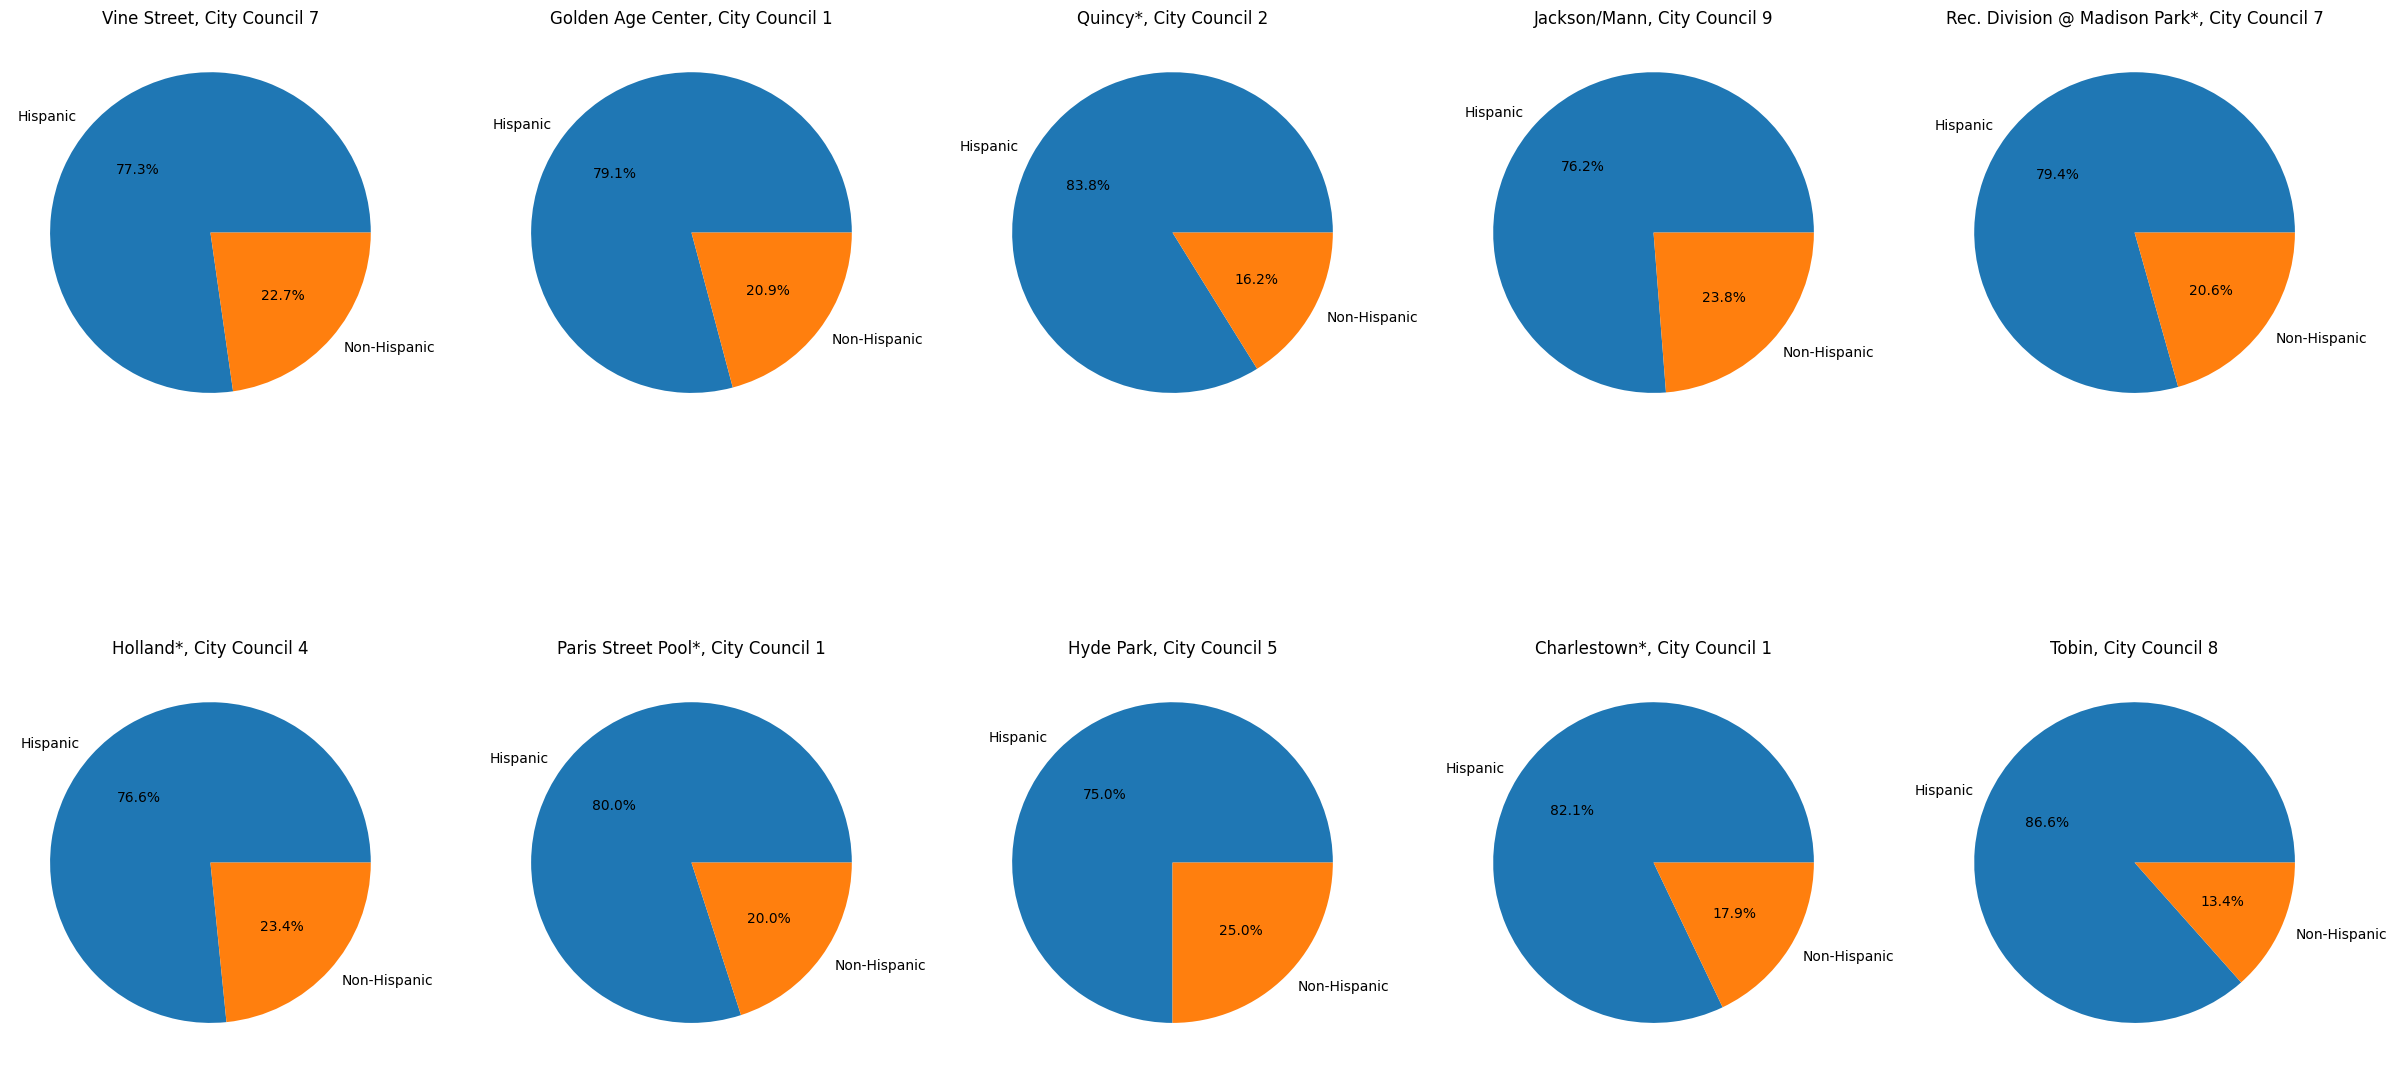

In [ ]:
labels = ['Hispanic', 'Non-Hispanic']
fig, ax = plt.subplots(2, 5)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(top_centers)):
    row = 0
    if i <=4:
        column = i
    else:
        column = i - 5

    if i >= 5:
        row = 1

    sizes = [top_centers.iloc[i]['num_non_hispanic'], top_centers.iloc[i]['num_hispanic']]
    victim_labels = labels.copy()
    to_remove = False
    for j in range(len(sizes)):
        if sizes[j] == 0:
            victim_labels[j] = None
            to_remove = True
    if to_remove:
        new_victim_labels = [label for label in victim_labels if label is not None]
        sizes = [size for size in sizes if size != 0]
    else:
        new_victim_labels = victim_labels

    title = top_centers.iloc[i]['SITE'] + ", City Council " + str(top_centers.iloc[i]['city_council_id'])
    ax[row, column].pie(sizes, labels=new_victim_labels, autopct='%1.1f%%')
    ax[row, column].title.set_text(title)

plt.show()


Key Findings:
In every Community Center on the top 10 list, more than 75% of the victims are Hispanic. The Community Center at Tobin (City Council 8) has the highest number of Hispanic victims out of the Community Centers in the top 10 list at 86.6%. The Community Center at Hyde Park (City Council 5) has the highest number of Non-Hispanic victims, with 25%.

District 4 Community Centers

In [ ]:
community_centers_district_4 = community_centers.loc[community_centers['city_council_id']==4]
community_centers_district_4 = community_centers_district_4.drop(community_centers_district_4.loc[community_centers_district_4['FID'] == 34].index) # Grove Hall has no recorded count of victims

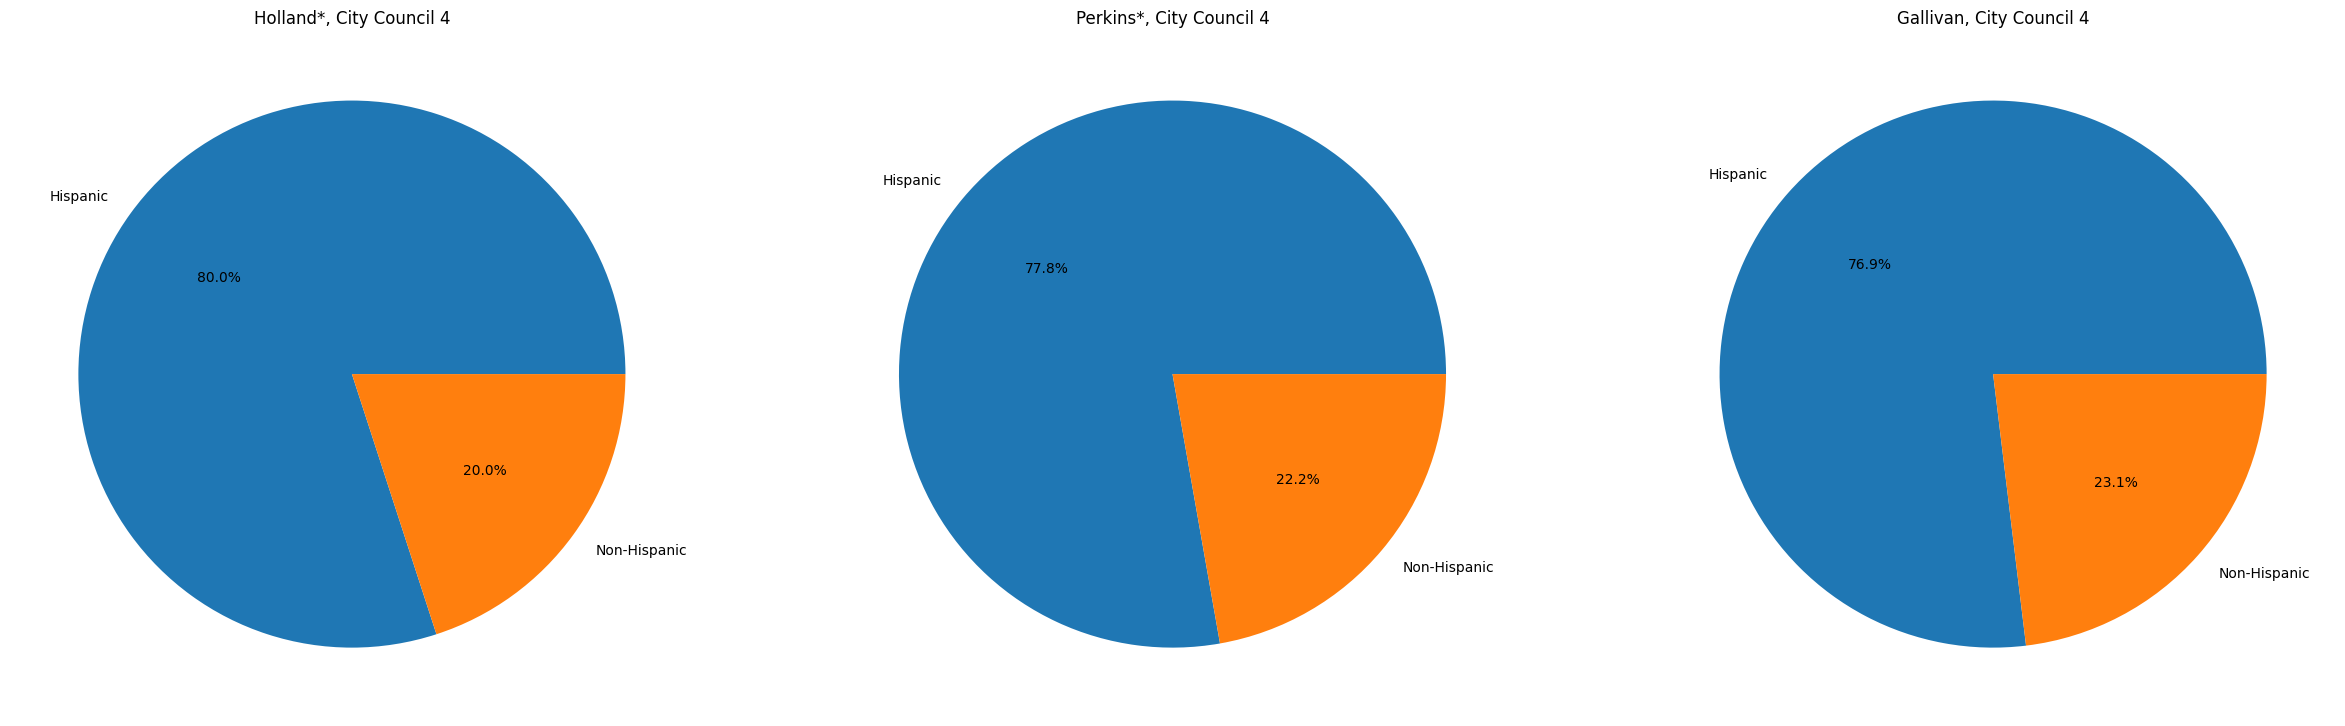

In [ ]:
labels = ['Hispanic', 'Non-Hispanic']
fig, ax = plt.subplots(1, 3)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(community_centers_district_4)):
    sizes = [community_centers_district_4.iloc[i]['num_non_hispanic'], community_centers_district_4.iloc[i]['num_hispanic']]
    victim_labels = labels.copy()
    to_remove = False
    for j in range(len(sizes)):
        if sizes[j] == 0:
            victim_labels[j] = None
            to_remove = True
    if to_remove:
        new_victim_labels = [label for label in victim_labels if label is not None]
        sizes = [size for size in sizes if size != 0]
    else:
        new_victim_labels = victim_labels

    title = community_centers_district_4.iloc[i]['SITE'] + ", City Council " + str(community_centers_district_4.iloc[i]['city_council_id'])
    ax[i].pie(sizes, labels=new_victim_labels, autopct='%1.1f%%')
    ax[i].title.set_text(title)

plt.show()

Key Findings:

We found that for the 3 community centers in District 4, Hispanic residents are more affected, similar to what was seen in the top 10 Community Centers, compared to Non-Hispanic ones. Similar to what was seen in the top 10 Community Centers, more than 75% of the victims are Hispanic in the District 4 Community Centers. Out of these 3, Holland has the highest percentage of Hispanic victims at 80%, while Gallivan has the highest percentage of Non-Hispanic victims at 23.1%.
